# **Examen P1 APAUT II Jueves**

In [ ]:
#imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from KNNp import KNNp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.neighbors import KNeighborsClassifier
from KNNClassifier import KNNClassifier

## **1. KNN**
### **1.1. KNN ponderado**

Crear un programa $KNNp$ en python a partir del programa realizado para la práctica 1, que implementará un modelo KNN con ponderación de los vecinos.

[Ver KNNp.py](./KNNp.py)

1. Por simplicidad, fije los hiperparámetros en $k=5$ vecinos próximos, metrics=’Euclidean’. Separe el conjunto de datos en un 80 % de muestras de entrenamiento y un 20 % de test.

2. Asigne un rango 'r' a cada vecino próximo, según su orden de vecinidad.

3. En el conteo de vecinos de cada clase, usar una ponderación exp (−q.r) para cada r-ésimo vecino. La potencia $q=0$ recupera el KNN sin ponderación.
Asigne un rango ’r’ a cada vecino próximo, según su orden de vecinidad

4. Asigne a cada muestra la clase con más vecinos próximos ponderados.

In [2]:
# 1) Cargar y preparar los datos
data = pd.read_csv('data.csv')
y = data['diagnosis']
y = y.map({'M': 1, 'B': 0}) 
X = data.drop(columns=['id', 'diagnosis', "Unnamed: 32"])   

# 2) Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Escalar y normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
k = 5
for q in [0.0, 1.0]:
    model = KNNp(k=k, q=q, distance_metric='euclidean').fit(X_train_scaled, y_train)
    tr = accuracy_score(y_train, model.predict(X_train_scaled))
    te = accuracy_score(y_test,  model.predict(X_test_scaled))
    print(f"q={q:.1f} -> train={tr:.4f}, test={te:.4f}")

q=0.0 -> train=0.9780, test=0.9561
q=1.0 -> train=1.0000, test=0.9298


## **1.2. Optimización del rango**

1. Use un bucle para variar el valor de la potencia ’q’ entre 0 y 2, con paso 0,1.

In [4]:
qs = np.round(np.arange(0, 2.0 + 1e-9, 0.1), 2)
train_acc, test_acc = [], []

for q in qs:
    mdl = KNNp(k=5, q=q, distance_metric='euclidean')
    mdl.fit(X_train_scaled, y_train)
    train_acc.append(accuracy_score(y_train, mdl.predict(X_train_scaled)))
    test_acc.append(accuracy_score(y_test,  mdl.predict(X_test_scaled)))

best_q = float(qs[int(np.argmax(test_acc))])

2. Muestre en una gráfica el accuracy frente al hiperparámetro ’q’, tanto para el conjunto de entrenamiento como para el de test. ¿Cuál es el valor óptimo de ’q’ ?

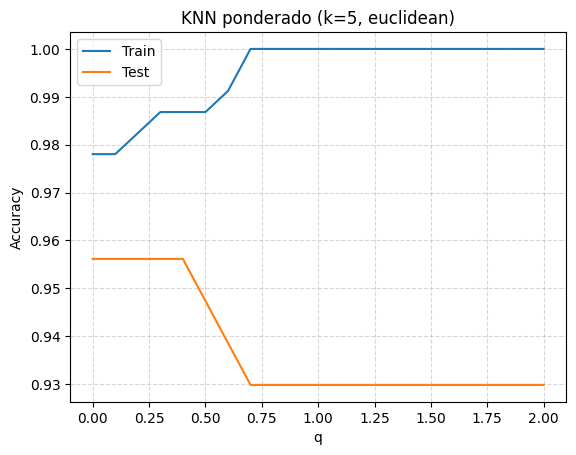

Mejor q: 0.0 con accuracy test = 0.9561


In [5]:
plt.plot(qs, train_acc, label='Train')
plt.plot(qs, test_acc, label='Test')
plt.xlabel('q')
plt.ylabel('Accuracy')
plt.title('KNN ponderado (k=5, euclidean)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print(f"Mejor q: {best_q} con accuracy test = {max(test_acc):.4f}")

3. Repita la gráfica anterior, pero ahora realizando validación cruzada.

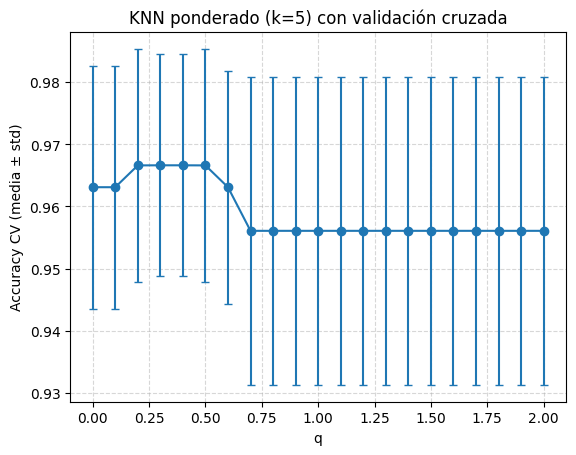

Mejor q (CV): 0.3 con accuracy CV = 0.9666 ± 0.0179


In [6]:
# Validación cruzada vs q (CV en todo X,y con escalado dentro del Pipeline)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_means, cv_stds = [], []

for q in qs:
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knnp', KNNp(k=5, q=q, distance_metric='euclidean'))
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

best_q_cv = float(qs[int(np.argmax(cv_means))])

plt.errorbar(qs, cv_means, yerr=cv_stds, fmt='-o', capsize=3)
plt.xlabel('q')
plt.ylabel('Accuracy CV (media ± std)')
plt.title('KNN ponderado (k=5) con validación cruzada')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Mejor q (CV): {best_q_cv} con accuracy CV = {max(cv_means):.4f} ± {cv_stds[int(np.argmax(cv_means))]:.4f}")

## **2. Selección de Atributos**
En la pr ́actica 1 hemos realizado un proceso de selección de atributos usando el método SelectKBest la biblioteca sklearn. En ese examen se probará con otro método:
from sklearn.feature_selection import SelectPercentile, chi2
X_new = SelectPercentile(chi2, percentile=10).fit_transform(X, y)
En ese caso se us ́o un percentil de 10 % de los atributos.

1. Pruebe con la dependencia de la m ́etrica accuracy respeto al hiperpar ́ametro
’percentile’, variando entre 10 y 100, con paso 5 dentro de un bucle.


In [ ]:
# Celda: Mejor percentil (selección con CV en train, evaluación informativa en test)
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import accuracy_score

k_fijo = 5
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectPercentile(chi2)),
    ('clf', KNNClassifier(k=k_fijo, distance_metric='euclidean'))
])

param_grid = {
    'feature_selection__percentile': np.arange(10, 101, 5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

best_percentile = grid.best_params_['feature_selection__percentile']
best_cv_acc = grid.best_score_
best_est = grid.best_estimator_
test_acc_best = accuracy_score(y_test, best_est.predict(X_test))

print(f"Mejor percentil (CV): {best_percentile}")
print(f"Mejor accuracy CV: {best_cv_acc:.4f}")
print(f"Accuracy test en mejor percentil: {test_acc_best:.4f}")

Mejor percentil (CV): 90
Mejor accuracy CV: 0.9758
Accuracy en test con ese percentil: 0.9649


2. Muestre en una gr ́afica el accuracy frente al hiperpar ́ametro ’percentile’,
tanto para el conjunto de entrenamiento como para el de test. ¿Cu ́al es el
valor  ́optimo de ’percentile’ ?

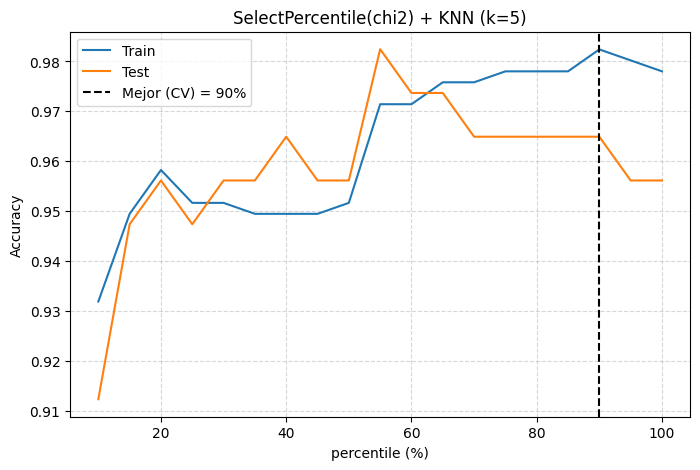

Accuracy test en mejor percentil (CV=90%): 0.9649


In [ ]:
# Celda: Gráfica accuracy vs percentil (sin usar test para seleccionar)
percentiles = list(range(10, 101, 5))
train_acc_pct, test_acc_pct = [], []

for pct in percentiles:
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('sel', SelectPercentile(chi2, percentile=pct)),
        ('clf', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
    ])
    pipe.fit(X_train, y_train)
    y_tr = pipe.predict(X_train)
    y_te = pipe.predict(X_test)
    train_acc_pct.append(accuracy_score(y_train, y_tr))
    test_acc_pct.append(accuracy_score(y_test, y_te))

plt.figure(figsize=(8,5))
plt.plot(percentiles, train_acc_pct, label="Train")
plt.plot(percentiles, test_acc_pct, label="Test")
if 'best_percentile' in globals():
    plt.axvline(best_percentile, color='k', linestyle='--', label=f"Mejor (CV) = {best_percentile}%")
plt.xlabel("percentile (%)")
plt.ylabel("Accuracy")
plt.title("SelectPercentile(chi2) + KNN (k=5)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()